<a href="https://colab.research.google.com/github/LinjieW/SummaryOfLoanSuspension/blob/main/%E2%80%9Cdca_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

[*********************100%%**********************]  1 of 1 completed


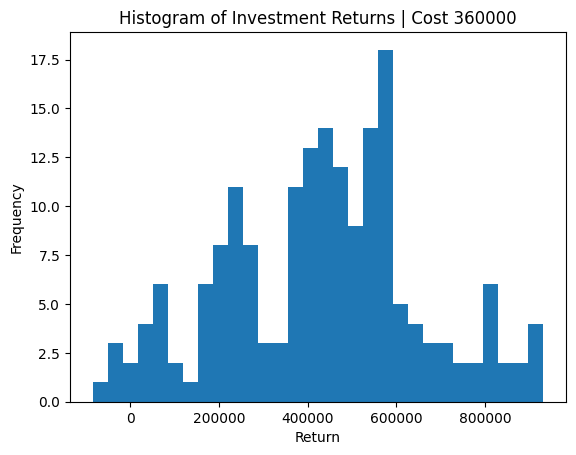

Percentage of Negative ROI: 2.20%
Best Starting Date: 2011-09-01, Final Value: 1291083.64, Return: 931083.64
Worst Starting Date: 1999-04-01, Final Value: 275550.08, Return: -84449.92


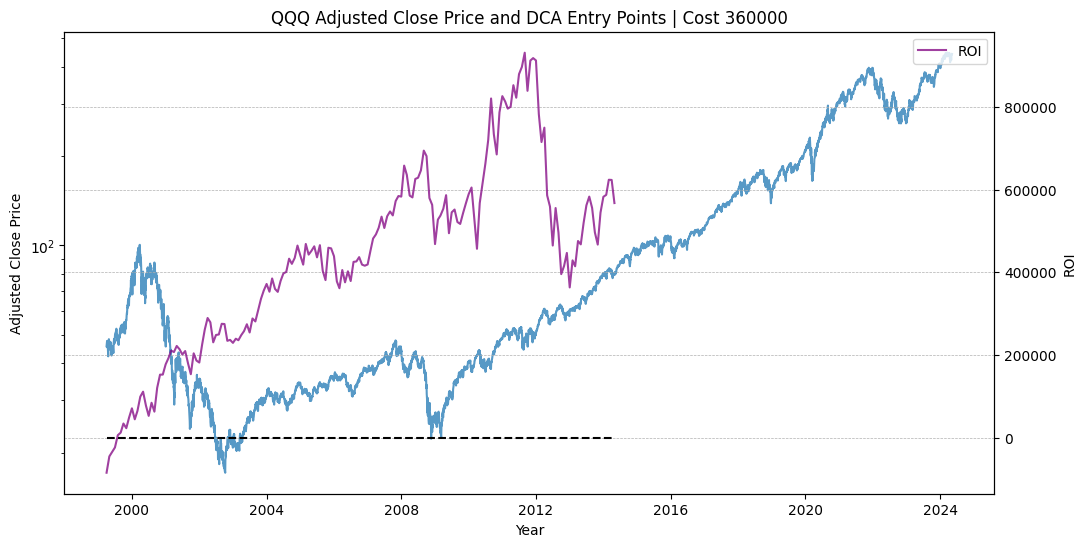

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulation settings
investment_horizon = 10  # years
monthly_investment = 3000  # USD

# Fetch historical data for QQQ
qqq = yf.download('QQQ', start='1999-04-01')

# Calculate monthly returns
qqq_monthly = qqq['Adj Close'].resample('M').last().pct_change().dropna()

def simulate_dca(start_date, investment_horizon=5, monthly_investment=2000):

    end_date = start_date + pd.DateOffset(years=investment_horizon)
    # Ensure end_date aligns with the data, adjusting if beyond the dataset's end
    if end_date > qqq_monthly.index[-1]:
        return np.nan  # Return NaN if the simulation period exceeds available data

    period_returns = qqq_monthly[start_date:end_date]
    portfolio_value = 0
    for monthly_return in period_returns:
        portfolio_value = (portfolio_value + monthly_investment) * (1 + monthly_return)
    return portfolio_value

simulations = {}

# Run simulations
end_date = pd.to_datetime('2024-05-11') - pd.DateOffset(years=investment_horizon)
for start_date in pd.date_range(start='1999-04-01',
                                end=end_date,
                                freq='MS'):
    final_value = simulate_dca(start_date,
                               investment_horizon = investment_horizon,
                               monthly_investment = monthly_investment)
    simulations[start_date] = final_value

cost_total = monthly_investment * investment_horizon * 12

# Convert simulations to DataFrame for analysis
sim_results = pd.DataFrame(list(simulations.items()), columns=['StartDate', 'FinalValue'])
sim_results['Return'] = sim_results['FinalValue'] - cost_total

# Calculate the number of periods with a negative ROI
negative_roi_count = (sim_results['Return'] < 0).sum()

# Calculate the total number of periods simulated
total_periods = sim_results.shape[0]

# Calculate the percentage of periods with a negative ROI
percentage_negative_roi = (negative_roi_count / total_periods) * 100

# Plot histogram of returns
plt.hist(sim_results['Return'], bins=30)
plt.title(f'Histogram of Investment Returns | Cost {cost_total}')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

# Find best and worst starting dates
best_start = sim_results.loc[sim_results['Return'].idxmax()]
worst_start = sim_results.loc[sim_results['Return'].idxmin()]

print(f"Percentage of Negative ROI: {percentage_negative_roi:.2f}%")
print(f"Best Starting Date: {best_start['StartDate'].date()}, Final Value: {best_start['FinalValue']:.2f}, Return: {best_start['Return']:.2f}")
print(f"Worst Starting Date: {worst_start['StartDate'].date()}, Final Value: {worst_start['FinalValue']:.2f}, Return: {worst_start['Return']:.2f}")


plt.figure(figsize=(12, 6))

# Plot QQQ adjusted close prices
plt.semilogy(qqq.index, qqq['Adj Close'], label='QQQ Adjusted Close', alpha=0.75)
plt.xlabel('Year')
plt.ylabel('Adjusted Close Price')

# Create a secondary y-axis for ROI
ax2 = plt.gca().twinx()
ax2.plot(sim_results['StartDate'], sim_results['Return'], label='ROI', alpha=0.75, color='purple')
ax2.plot(sim_results['StartDate'], sim_results['Return'] * 0, color='black', ls='--')
ax2.set_ylabel('ROI')

plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

plt.title(f'QQQ Adjusted Close Price and DCA Entry Points | Cost {cost_total}')
plt.legend(loc='upper left')

# Add legend for the second axis manually
ax2.legend(['ROI'], loc='upper right')

plt.show()
